Starting training...
Epoch 0
Total Loss: 45.1459
Dynamics Loss: 45.1355
Energy Loss: 0.0209

Epoch 10
Total Loss: 3.3764
Dynamics Loss: 3.3661
Energy Loss: 0.0206

Epoch 20
Total Loss: 1.2984
Dynamics Loss: 1.2881
Energy Loss: 0.0205

Epoch 30
Total Loss: 0.6821
Dynamics Loss: 0.6718
Energy Loss: 0.0206

Epoch 40
Total Loss: 0.2659
Dynamics Loss: 0.2556
Energy Loss: 0.0207

Epoch 50
Total Loss: 0.1353
Dynamics Loss: 0.1250
Energy Loss: 0.0207

Epoch 60
Total Loss: 0.1249
Dynamics Loss: 0.1145
Energy Loss: 0.0207

Epoch 70
Total Loss: 0.1110
Dynamics Loss: 0.1006
Energy Loss: 0.0207

Epoch 80
Total Loss: 0.1004
Dynamics Loss: 0.0901
Energy Loss: 0.0207

Epoch 90
Total Loss: 0.0669
Dynamics Loss: 0.0566
Energy Loss: 0.0206



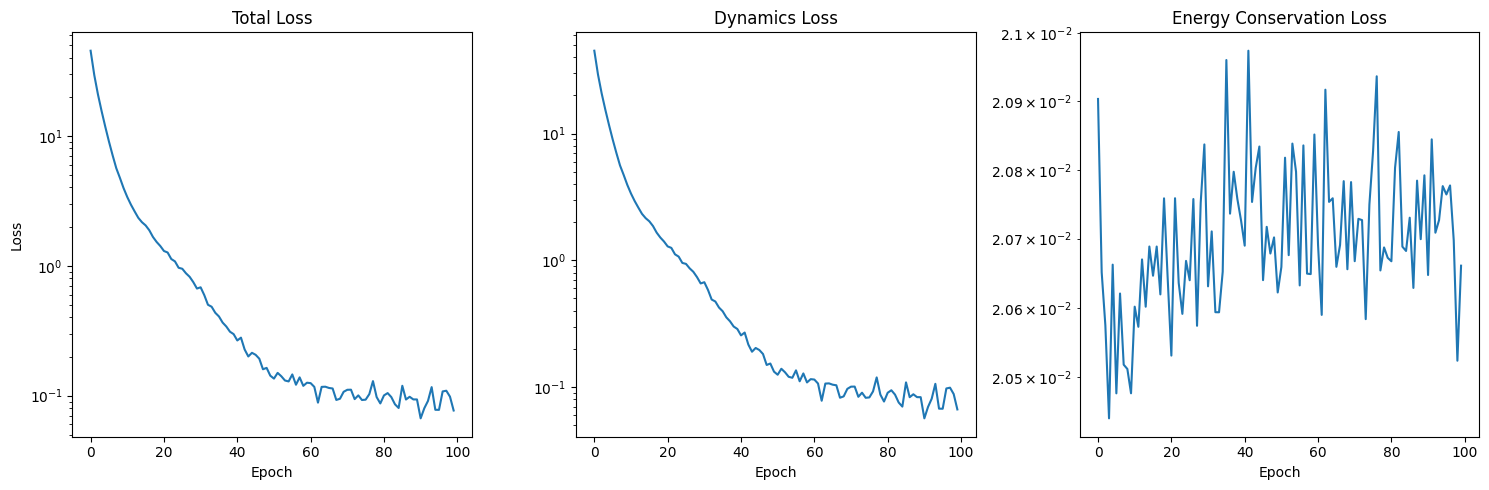

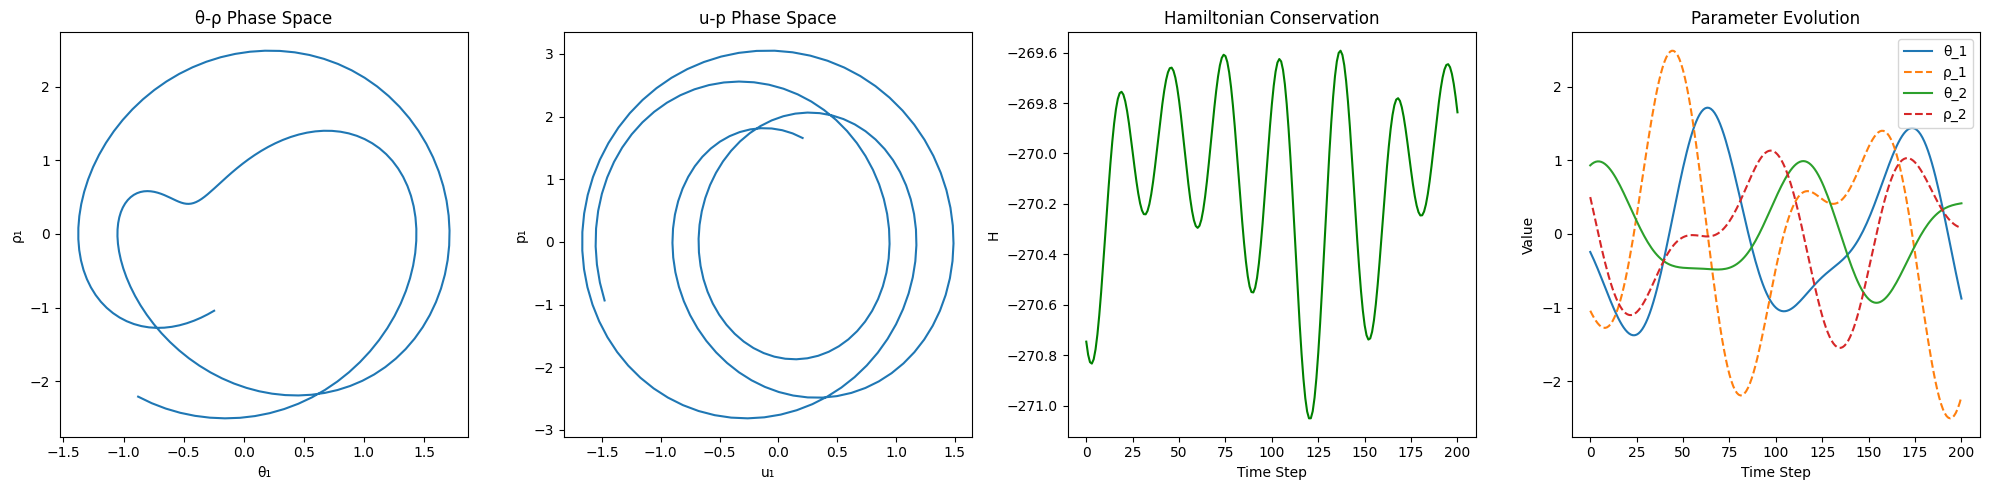

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class IntegratedPMLHNN(tf.keras.Model):
    def __init__(self, param_dim=2, aux_dim=2, hidden_dim=100):
        """
        Integrated Pseudo-Marginal Latent Hamiltonian Neural Network
        Combines standard L-HNN with pseudo-marginal approach

        Args:
            param_dim: Dimension of parameter space θ
            aux_dim: Dimension of auxiliary variables u
            hidden_dim: Dimension of hidden layers
        """
        super().__init__()
        self.param_dim = param_dim
        self.aux_dim = aux_dim

        # Network for potential energy V(θ, u)
        self.potential_net = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation='tanh'),
            tf.keras.layers.Dense(hidden_dim, activation='tanh'),
            tf.keras.layers.Dense(1)
        ])

    def kinetic_energy(self, rho, u, p):
        """Compute kinetic energy term"""
        return 0.5 * (tf.reduce_sum(rho**2, axis=1, keepdims=True) +
                     tf.reduce_sum(u**2, axis=1, keepdims=True) +
                     tf.reduce_sum(p**2, axis=1, keepdims=True))

    def call(self, inputs):
        """Compute full Hamiltonian H(θ,ρ,u,p)"""
        theta, rho, u, p = inputs
        V = self.potential_net(tf.concat([theta, u], axis=1))
        T = self.kinetic_energy(rho, u, p)
        return V + T

    @tf.function
    def compute_gradients(self, theta, rho, u, p):
        """Compute gradients for equations of motion"""
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([theta, rho, u, p])
            H = self.call([theta, rho, u, p])

        dH_dtheta = tape.gradient(H, theta)
        dH_drho = tape.gradient(H, rho)
        dH_du = tape.gradient(H, u)
        dH_dp = tape.gradient(H, p)

        del tape
        return dH_dtheta, dH_drho, dH_du, dH_dp

def leapfrog_step(model, theta, rho, u, p, dt):
    """Single leapfrog integration step"""
    # Half step momentum
    dH_dtheta, _, dH_du, _ = model.compute_gradients(theta, rho, u, p)
    rho_half = rho - 0.5 * dt * dH_dtheta
    p_half = p - 0.5 * dt * (u + dH_du)

    # Full step position
    _, dH_drho, _, dH_dp = model.compute_gradients(theta, rho_half, u, p_half)
    theta_new = theta + dt * dH_drho
    u_new = u + dt * dH_dp

    # Half step momentum
    dH_dtheta, _, dH_du, _ = model.compute_gradients(theta_new, rho_half, u_new, p_half)
    rho_new = rho_half - 0.5 * dt * dH_dtheta
    p_new = p_half - 0.5 * dt * (u_new + dH_du)

    return theta_new, rho_new, u_new, p_new

def generate_training_data(model, n_trajectories=100, n_steps=50, dt=0.1):
    """Generate training data with pseudo-marginal dynamics"""
    def log_prior(theta):
        """Gaussian prior"""
        return 0.5 * tf.reduce_sum(theta**2, axis=1, keepdims=True)

    def simulated_likelihood(theta, u):
        """Simulated likelihood"""
        return 0.5 * tf.reduce_sum((theta - u)**2, axis=1, keepdims=True)

    all_states = []
    all_derivs = []

    for _ in range(n_trajectories):
        # Initialize state
        theta = tf.random.normal([1, model.param_dim])
        rho = tf.random.normal([1, model.param_dim])
        u = tf.random.normal([1, model.aux_dim])
        p = tf.random.normal([1, model.aux_dim])

        states = []
        derivs = []

        for _ in range(n_steps):
            # Record current state
            states.append([theta, rho, u, p])

            # Compute dynamics
            with tf.GradientTape(persistent=True) as tape:
                tape.watch([theta, u])
                V = log_prior(theta) + simulated_likelihood(theta, u)

            grad_theta = tape.gradient(V, theta)
            grad_u = tape.gradient(V, u)
            del tape

            dtheta_dt = rho
            drho_dt = -grad_theta
            du_dt = p
            dp_dt = -u - grad_u

            derivs.append([dtheta_dt, drho_dt, du_dt, dp_dt])

            # Leapfrog integration
            theta, rho, u, p = leapfrog_step(model, theta, rho, u, p, dt)

        all_states.extend(states)
        all_derivs.extend(derivs)

    # Convert to tensors
    all_states = [tf.concat(x, axis=0) for x in zip(*all_states)]
    all_derivs = [tf.concat(x, axis=0) for x in zip(*all_derivs)]

    return tf.data.Dataset.from_tensor_slices((
        tuple(all_states), tuple(all_derivs)
    )).shuffle(1000).batch(32)

def train_model(model, n_epochs=100, learning_rate=1e-3):
    """Train the model"""
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Training metrics
    losses = {
        'total': [],
        'dynamics': [],
        'energy': []
    }

    # Generate training data
    train_data = generate_training_data(model)

    print("Starting training...")
    for epoch in range(n_epochs):
        epoch_losses = {k: 0.0 for k in losses.keys()}
        n_batches = 0

        for states, derivs in train_data:
            theta, rho, u, p = states
            true_dtheta, true_drho, true_du, true_dp = derivs

            with tf.GradientTape() as tape:
                # Dynamics loss
                dH_dtheta, dH_drho, dH_du, dH_dp = model.compute_gradients(theta, rho, u, p)
                dynamics_loss = (
                    tf.reduce_mean(tf.square(dH_drho - true_dtheta)) +
                    tf.reduce_mean(tf.square(-dH_dtheta - true_drho)) +
                    tf.reduce_mean(tf.square(dH_dp - true_du)) +
                    tf.reduce_mean(tf.square(-dH_du + u - true_dp))
                )

                # Energy conservation
                H_start = model.call([theta, rho, u, p])
                theta_end, rho_end, u_end, p_end = leapfrog_step(model, theta, rho, u, p, dt=0.1)
                H_end = model.call([theta_end, rho_end, u_end, p_end])
                energy_loss = tf.reduce_mean(tf.square(H_end - H_start))

                # Total loss
                total_loss = dynamics_loss + 0.5 * energy_loss

            # Update model
            grads = tape.gradient(total_loss, model.trainable_variables)
            grads = [tf.clip_by_norm(g, 1.0) for g in grads]
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Record losses
            epoch_losses['total'] += total_loss
            epoch_losses['dynamics'] += dynamics_loss
            epoch_losses['energy'] += energy_loss
            n_batches += 1

        # Average losses
        for k in losses.keys():
            losses[k].append(epoch_losses[k] / n_batches)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}")
            print(f"Total Loss: {losses['total'][-1]:.4f}")
            print(f"Dynamics Loss: {losses['dynamics'][-1]:.4f}")
            print(f"Energy Loss: {losses['energy'][-1]:.4f}\n")

    return losses

def visualize_training(losses):
    """Visualize training progress"""
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.plot(losses['total'])
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')

    plt.subplot(132)
    plt.plot(losses['dynamics'])
    plt.title('Dynamics Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')

    plt.subplot(133)
    plt.plot(losses['energy'])
    plt.title('Energy Conservation Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

def visualize_trajectories(model, theta_init, n_steps=200, dt=0.05):
    """Visualize system trajectories"""
    # Initialize state
    theta = theta_init
    rho = tf.random.normal(theta.shape)
    u = tf.random.normal([theta.shape[0], model.aux_dim])
    p = tf.random.normal([theta.shape[0], model.aux_dim])

    # Track trajectories
    trajectories = {
        'theta': [theta.numpy()],
        'rho': [rho.numpy()],
        'u': [u.numpy()],
        'p': [p.numpy()],
        'H': [model.call([theta, rho, u, p]).numpy()]
    }

    # Generate trajectory
    for _ in range(n_steps):
        theta, rho, u, p = leapfrog_step(model, theta, rho, u, p, dt)

        trajectories['theta'].append(theta.numpy())
        trajectories['rho'].append(rho.numpy())
        trajectories['u'].append(u.numpy())
        trajectories['p'].append(p.numpy())
        trajectories['H'].append(model.call([theta, rho, u, p]).numpy())

    # Convert to arrays
    trajectories = {k: np.array(v) for k, v in trajectories.items()}

    # Plot results
    plt.figure(figsize=(20, 5))

    plt.subplot(141)
    plt.plot(trajectories['theta'][:, 0, 0], trajectories['rho'][:, 0, 0])
    plt.xlabel('θ₁')
    plt.ylabel('ρ₁')
    plt.title('θ-ρ Phase Space')

    plt.subplot(142)
    plt.plot(trajectories['u'][:, 0, 0], trajectories['p'][:, 0, 0])
    plt.xlabel('u₁')
    plt.ylabel('p₁')
    plt.title('u-p Phase Space')

    plt.subplot(143)
    plt.plot(range(len(trajectories['H'])), trajectories['H'][:, 0], 'g-')
    plt.xlabel('Time Step')
    plt.ylabel('H')
    plt.title('Hamiltonian Conservation')

    plt.subplot(144)
    for i in range(model.param_dim):
        plt.plot(range(len(trajectories['theta'])),
                trajectories['theta'][:, 0, i],
                label=f'θ_{i+1}')
        plt.plot(range(len(trajectories['rho'])),
                trajectories['rho'][:, 0, i],
                '--',
                label=f'ρ_{i+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Parameter Evolution')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return trajectories

def main():
    # Set random seed
    tf.random.set_seed(42)

    # Create model
    model = IntegratedPMLHNN(param_dim=2, aux_dim=2)

    # Train model
    losses = train_model(model, n_epochs=100)

    # Visualize training
    visualize_training(losses)

    # Visualize trajectories
    theta_init = tf.random.normal([1, 2])
    visualize_trajectories(model, theta_init)

if __name__ == "__main__":
    main()